# Use pretrained models of scVI-hub for CELLxGENE

This notebook was contributed by Can Ergen and Martin Kim.

Original article:
`Scvi-hub: an actionable repository for model-driven single cell analysis`

https://www.biorxiv.org/content/10.1101/2024.03.01.582887

The anndata object we're using here is a subset of the full CELLxGENE census data. Use: s3://cellxgene-contrib-public/models/scvi/2024-02-12/mus_musculus/adata_minified.h5ad

**Steps performed**:

1. Loading the minified data from AWS
2. Setting up minified model with minified data
3. Visualize the latent space
4. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [ ]:
!pip install --quiet scvi-colab
!pip install --quiet cellxgene-census
!pip install --quiet pybiomart
from scvi_colab import install

install()

In [1]:
import os
import tempfile

import numpy as np
import scanpy as sc
import scvi
from scvi.hub import HubModel
import torch
import seaborn as sns
import plotnine as p9
import cellxgene_census
import botocore

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.1.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We download a toy example here (all cells from the spinal cord). To download the full census use backup_url: https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata_minified.h5ad. Expect that the download of the full census takes ~30 minutes with a high bandwidth internet connection.

We share models for mouse at https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/mus_musculus (same folder structure).

In [4]:
adata_path = os.path.join(save_dir.name, "adata-spinal-cord-minified.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata-spinal-cord-minified.h5ad",
)

model = HubModel.pull_from_s3(
    s3_bucket="cellxgene-contrib-public",
    s3_path="models/scvi/2024-02-12/homo_sapiens/modelhub",
    pull_anndata=False,
    config=botocore.config.Config(signature_version=botocore.UNSIGNED)
)

adata, model

  0%|          | 0.00/45.1M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.


HubModel with:
local_dir: /tmp/tmptkfmseo4
model loaded? No
adata loaded? No
large_training_adata loaded? No
metadata:
HubMetadata(scvi_version='1.0.4', anndata_version='0.8.0', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')
model_card:


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
license: cc-by-4.0                                                                                                 

library_name: scvi-tools                                                                                           

tags:                                                                                                              

 • biology                                                                                                         
 • genomics                                                                                                        
 • single-cell                                                                                                     
 • model_cls_name:SCVI                                                                                             
 • scvi_version:1.0.4                                                                                              
 • anndata_version:0.8.0                                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                   Description                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

SCVI model trained on the homo_sapiens data of the CELLxGENE Discover Census.                                      

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                Model properties                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Many model properties are in the model tags. Some more are listed below.                                           

model_init_params:                                                                                                 

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
                                                                                                                   
     "n_hidden": 128,                                                                                              
                                                                                                                   
     "n_latent": 50,                                                                                               
                                                                                                                   
     "n_layers": 2,                                                                                                
                                                                                                                   
     "dropout_rate": 0.1,                                                                                          
                                                                                                                   
     "dispersion": "gene",                                                                                         
                                                                                                                   
     "gene_likelihood": "nb",                  

(AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 )

### Setup minified model

Census was trained on all primary cells. We don't encode covariates so inference and generating latent codes works without retraining on these batches. We have to subset to all training batches.
The setup will be optimized in a future version of scvi-tools.

In [5]:
del adata.uns["_scvi_adata_minify_type"]
model.load_model(adata=adata[adata.obs["is_primary_data"]].copy())
census_model = model.model

INFO     Loading model...                                                                                          
INFO     File /tmp/tmptkfmseo4/model.pt already downloaded                                                         


/usr/local/lib/python3.10/dist-packages/scvi/model/_scvi.py:155: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`


In [6]:
census_model_all = scvi.model.SCVI.load_query_data(adata, census_model)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 6006 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
/usr/local/lib/python3.10/dist-packages/scvi/model/_scvi.py:155: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`


For spinal cord less than a half of cells is labeled as primary cells, while the other cells are duplicated from this dataset. census_model_all contains all cells while census_model only contains primary cells.

In [7]:
adata.obs["is_primary_data"].value_counts()

is_primary_data
False    67707
True     49756
Name: count, dtype: int64

In [8]:
census_model.adata, census_model_all.adata

(AnnData object with n_obs × n_vars = 49756 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'deve

By default scvi-tools loads models as not minified. We set up the model here with minified data, so we minify the model using the respective obsm fields.

In [9]:
census_model.minify_adata(
    use_latent_qzm_key="_scvi_latent_qzm", use_latent_qzv_key="_scvi_latent_qzv"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


### Get the latent space and compute UMAP

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/loc

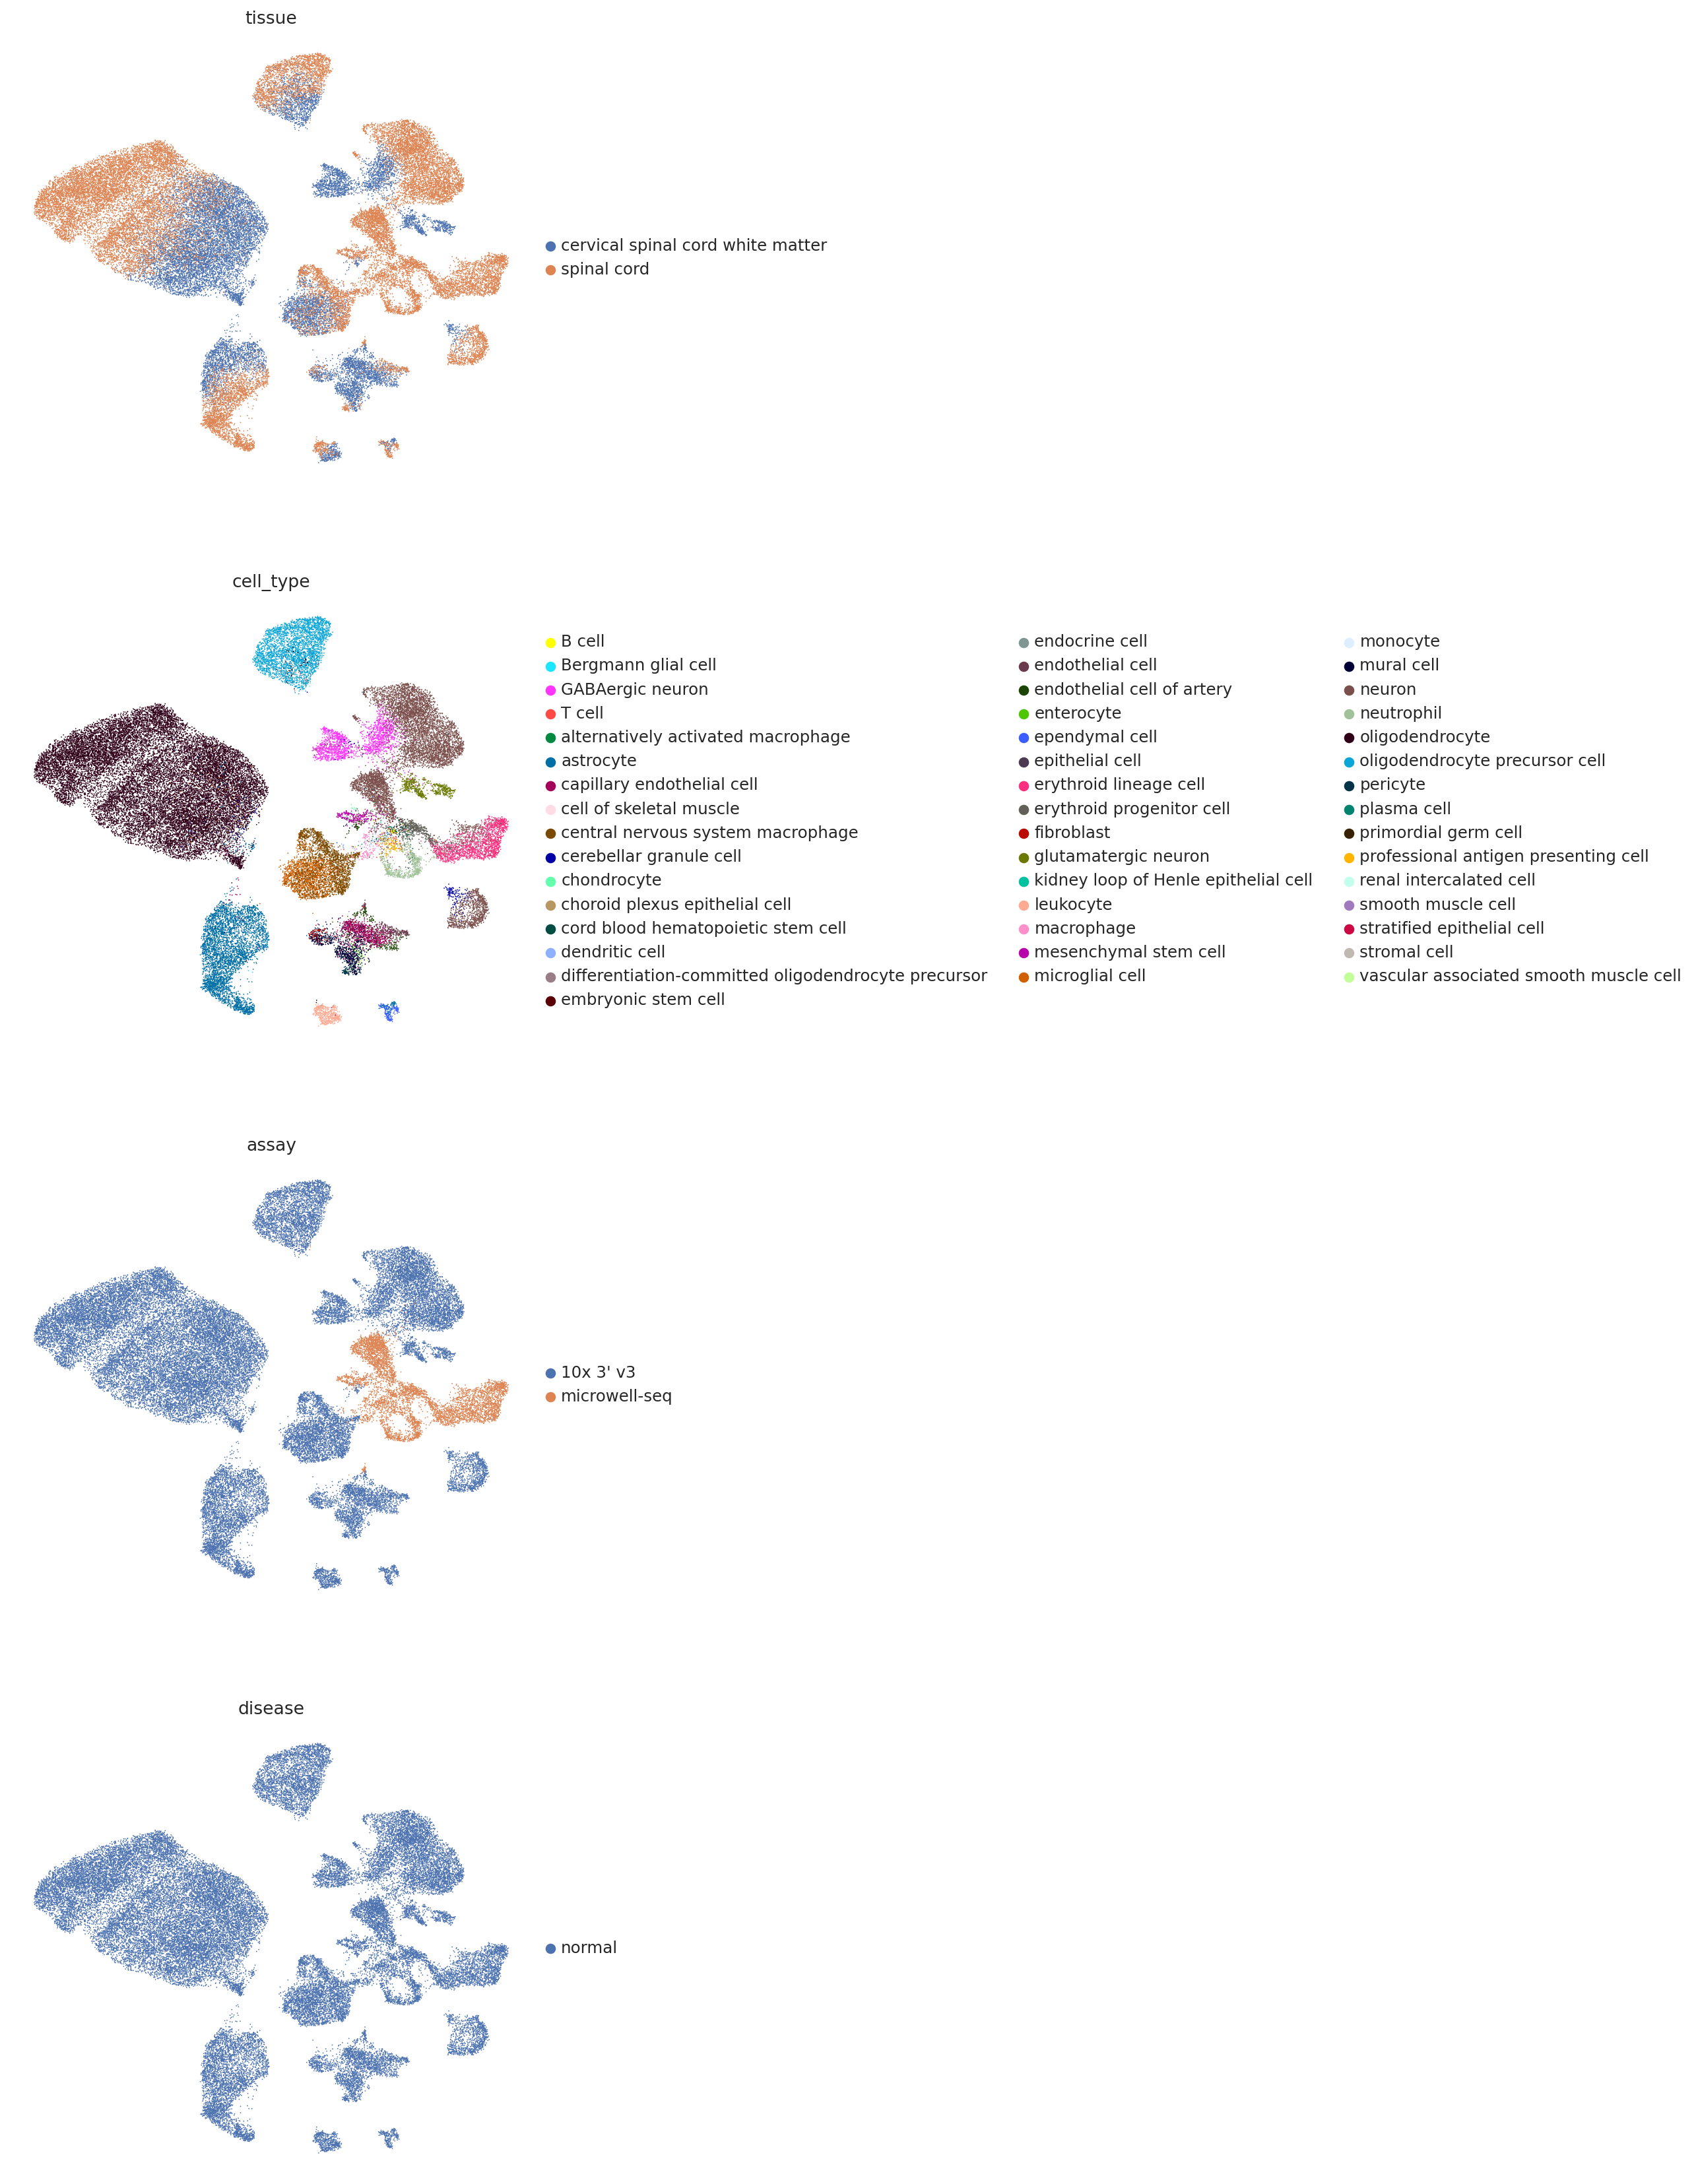

In [10]:
sc.pp.neighbors(census_model.adata, n_neighbors=20, use_rep="_scvi_latent_qzm")
sc.tl.umap(census_model.adata)
sc.pl.umap(
    census_model.adata, color=["tissue", "cell_type", "assay", "disease"], ncols=1
)

## Performing Differential Expression in scVI

While we only have access to the minified data, we can still perform downstream analysis using the generative part of the model.

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
2. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [11]:
# let's take a look at abundances of different cell types
print(
    census_model.adata.obs["cell_type"].value_counts(),
    "\n\n\n\n",
    census_model.adata.obs["tissue"].value_counts(),
)

cell_type
oligodendrocyte                                        20708
neuron                                                  7831
astrocyte                                               4449
oligodendrocyte precursor cell                          3191
microglial cell                                         1864
GABAergic neuron                                        1790
central nervous system macrophage                       1777
erythroid lineage cell                                  1684
capillary endothelial cell                               915
mural cell                                               879
neutrophil                                               708
erythroid progenitor cell                                606
glutamatergic neuron                                     576
leukocyte                                                542
endothelial cell of artery                               330
endothelial cell                                         247
mesenchymal st

scVI provides several options to identify the two populations of interest.

In [12]:
cell_type = "oligodendrocyte"
tissue1 = "spinal cord"
cell_idx1 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue1,
)
print(sum(cell_idx1), "cells from tissue", tissue1)

tissue2 = "cervical spinal cord white matter"
cell_idx2 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue2,
)
print(sum(cell_idx2), "cells of type", tissue2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

11547 cells from tissue spinal cord
9161 cells of type cervical spinal cord white matter


### Running DE analyses

A simple DE analysis can then be performed using the following command

In [13]:
de_change = census_model.differential_expression(
    idx1=cell_idx1, idx2=cell_idx2, all_stats=False
)

DE...: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

### Volcano plot with p-values

In [14]:
de_change["log10_pscore"] = np.log10(de_change["proba_not_de"] + 1e-6)
de_change = de_change.join(census_model.adata.var, how="inner")
de_change = de_change.loc[np.max(de_change[["scale1", "scale2"]], axis=1) > 1e-4]
de_change["feature_id"] = de_change.index
de_change.index = de_change["feature_name"]
de_change.head(20)

proba_de  proba_not_de  bayes_factor        scale1  \
feature_name                                                       
MRPL45P2           1.0           0.0     18.420681  1.241373e-04   
ZNF56              1.0           0.0     18.420681  2.487090e-04   
ZC3H11A            1.0           0.0     18.420681  4.556151e-04   
UBE2V1             1.0           0.0     18.420681  1.391806e-04   
MTRNR2L12          1.0           0.0     18.420681  2.140532e-07   
CNTNAP4            1.0           0.0     18.420681  1.275188e-05   
SNHG14             1.0           0.0     18.420681  1.229158e-03   
AC079610.1         1.0           0.0     18.420681  1.429315e-04   
RP11-156P1.3       1.0           0.0     18.420681  2.382505e-04   
ZNRD1ASP           1.0           0.0     18.420681  1.623187e-04   
MT-RNR2            1.0           0.0     18.420681  1.069519e-03   
MT-RNR1            1.0           0.0     18.420681  1.805049e-04   
MRPS31P5           1.0           0.0     18.420681  1.028972e-04   
MIR100HG           1.0           0.0     18.420681  2.159521e-03   
MAGI2-AS3          1.0           0.0     18.420681  4.450702e-04   
PANTR1             1.0           0.0     18.420681  2.101845e-04   
EIF1B-AS1          1.0           0.0     18.420681  2.955570e-04   
FAHD2CP            1.0           0.0     18.420681  2.060759e-04   
IQCJ-SCHIP1        1.0           0.0     18.420681  1.624369e-06   
EEF1G              1.0           0.0     18.420681  1.002509e-04   

                    scale2  pseudocounts  delta   lfc_mean  lfc_median  \
feature_name                                                             
MRPL45P2      1.820472e-07           0.0   0.25   9.534699    9.515192   
ZNF56         1.220339e-07           0.0   0.25  11.131757   11.138688   
ZC3H11A       1.022522e-04           0.0   0.25   2.193222    2.146631   
UBE2V1        8.504455e-06           0.0   0.25   4.084403    4.086278   
MTRNR2L12     1.380480e-04           0.0   0.25  -9.671575   -9.734825   
CNTNAP4       3.214481e-03           0.0   0.25  -7.929985   -7.919338   
SNHG14        3.914981e-07           0.0   0.25  11.876592   11.899238   
AC079610.1    1.561075e-06           0.0   0.25   6.612239    6.558727   
RP11-156P1.3  2.331705e-07           0.0   0.25  10.203146   10.209951   
ZNRD1ASP      1.122462e-05           0.0   0.25   3.913791    3.831207   
MT-RNR2       3.460731e-07           0.0   0.25  11.504828   11.358850   
MT-RNR1       1.182079e-07           0.0   0.25  10.432153   10.313975   
MRPS31P5      9.409919e-08           0.0   0.25  10.209138   10.181173   
MIR100HG      2.145932e-05           0.0   0.25   6.733459    6.718003   
MAGI2-AS3     2.449497e-07           0.0   0.25  11.039300   11.029654   
PANTR1        5.640911e-06           0.0   0.25   5.294885    5.297700   
EIF1B-AS1     2.838631e-07           0.0   0.25  10.233083   10.239212   
FAHD2CP       9.020513e-08           0.0   0.25  11.326140   11.325794   
IQCJ-SCHIP1   6.481781e-04           0.0   0.25  -8.606927   -8.566370   
EEF1G         6.923192e-07           0.0   0.25   7.307506    7.351298   

               lfc_std    lfc_min    lfc_max  is_de_fdr_0.05  log10_pscore  \
feature_name                                                                 
MRPL45P2      0.688605   7.474736  12.132449            True          -6.0   
ZNF56         0.687028   9.008451  13.545299            True          -6.0   
ZC3H11A       0.447086   0.718671   4.242967            True          -6.0   
UBE2V1        0.452460   2.507608   5.500891            True          -6.0   
MTRNR2L12     2.136825 -16.649040  -2.574574            True          -6.0   
CNTNAP4       0.750885 -14.578864  -1.209697            True          -6.0   
SNHG14        0.956227   8.627443  14.996069            True          -6.0   
AC079610.1    0.796206   4.353149  10.106512            True          -6.0   
RP11-156P1.3  0.794208   7.782471  12.800419            True          -6.0   
ZNRD1ASP      0.477907   2.692

In [15]:
gene_annotations = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "gene_biotype"],
)

In [16]:
gene_annotations.index = gene_annotations["ensembl_gene_id"]
gene_annotation_dict = gene_annotations["gene_biotype"].to_dict()
de_change["Biotype"] = [
    gene_annotation_dict.pop(i, "Unannotated") for i in de_change["feature_id"]
]
de_change["Biotype"].value_counts()

Biotype
protein_coding                        815
lncRNA                                 72
transcribed_unprocessed_pseudogene      7
Unannotated                             2
Mt_rRNA                                 2
transcribed_unitary_pseudogene          1
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


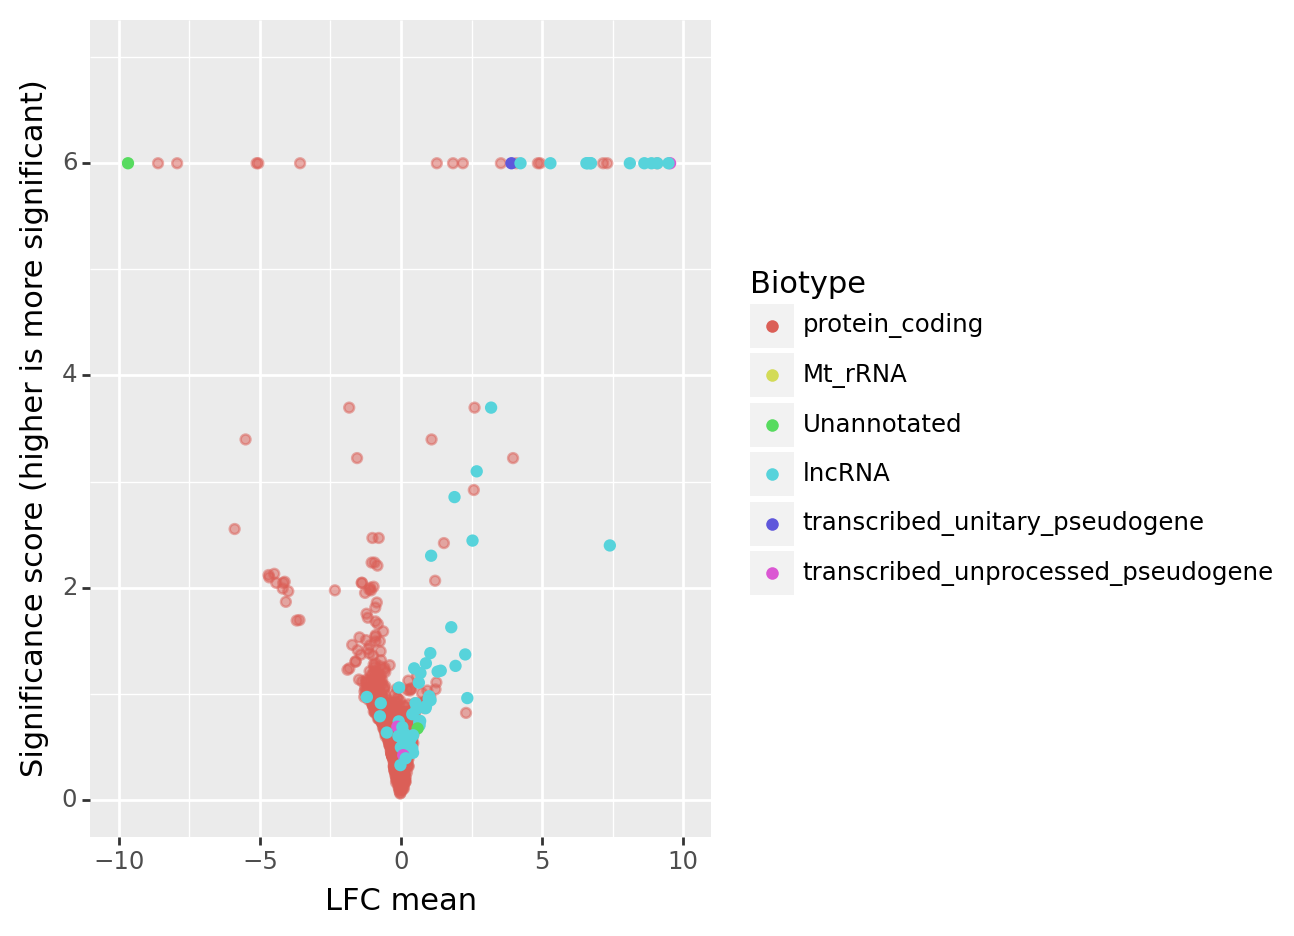

<Figure Size: (640 x 480)>

In [17]:
(
    p9.ggplot(de_change, p9.aes("lfc_mean", "-log10_pscore", color="Biotype"))
    + p9.geom_point(
        de_change.query("Biotype == 'protein_coding'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.xlim(-10, 10)  # Set x limits
    + p9.ylim(0, 7)  # Set y limits
    + p9.geom_point(de_change.query("Biotype != 'protein_coding'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
)

In [18]:
upregulated_genes = de_change.loc[
    de_change["lfc_median"] > 0, ["feature_id", "feature_name"]
].head(4)

Display generated counts from scVI model

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


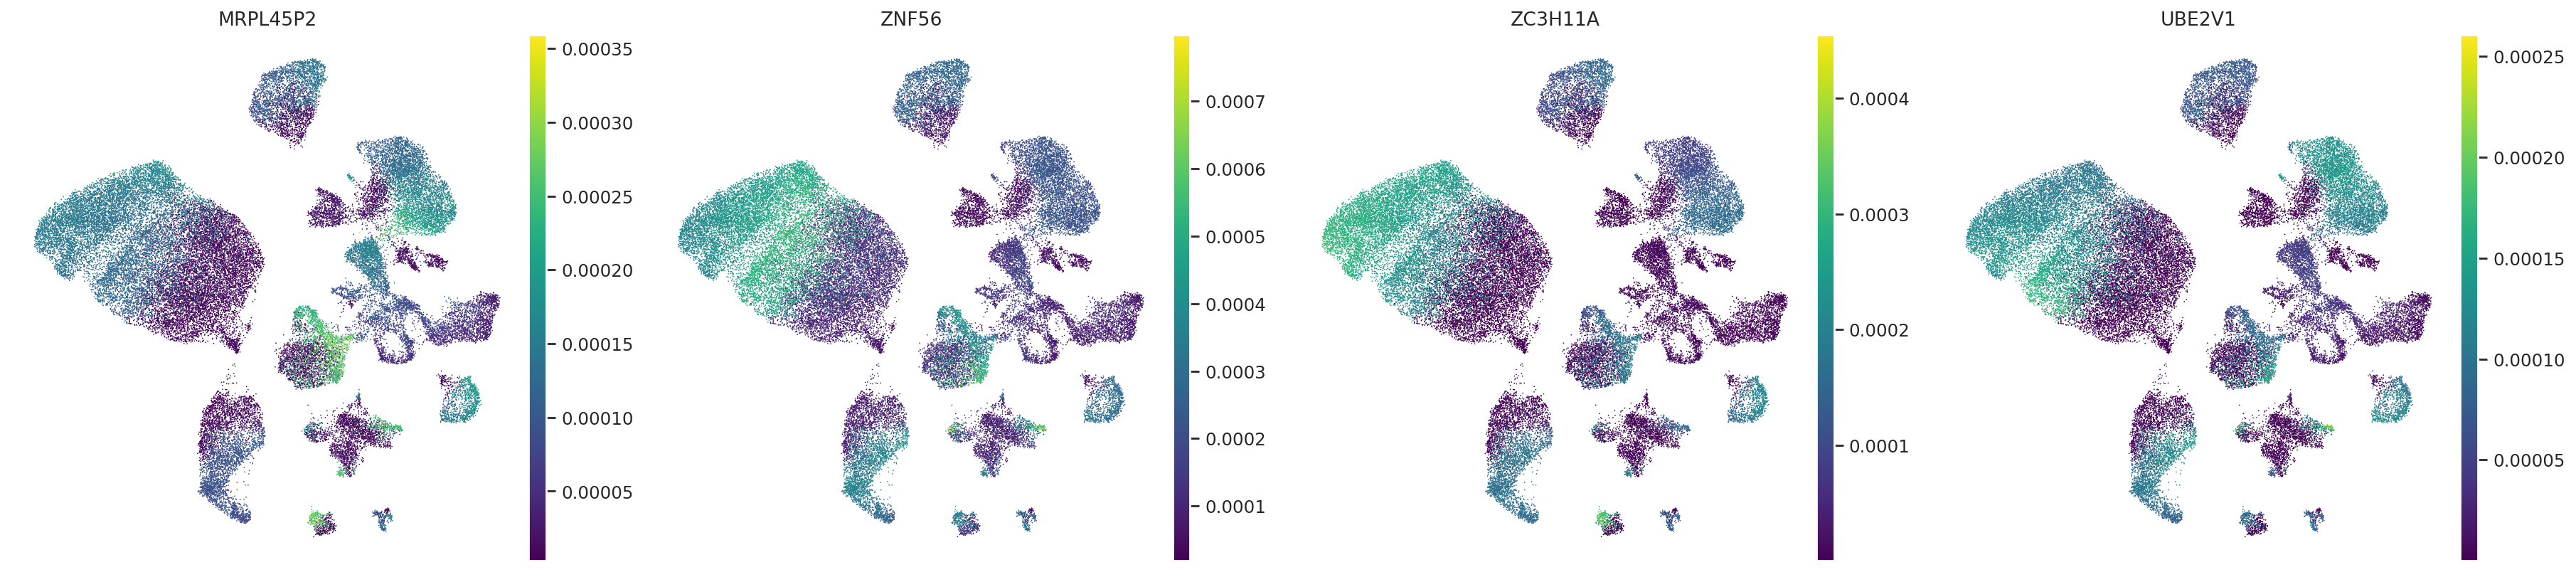

In [19]:
census_model.adata[
    :, upregulated_genes["feature_id"]
] = census_model.get_normalized_expression(
    gene_list=list(upregulated_genes["feature_id"]), n_samples=10
)
sc.pl.umap(
    census_model.adata,
    color=upregulated_genes["feature_name"],
    gene_symbols="feature_name",
    cmap="viridis",
)

## Performing differential expression and yield expression from census

Now we perform DE between each cell type vs all other cells and make a dotplot of the result.

#### Performing differential expression

In [20]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1 vs all results, contained in a DataFrame
change_per_cluster_de = census_model.differential_expression(
    adata=census_model.adata[census_model.adata.obs["assay"] == "10x 3' v3"],
    groupby="cell_type",
    all_stats=False,
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


DE...: 100%|██████████| 21/21 [01:46<00:00,  5.09s/it]


In [21]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [22]:
change_per_cluster_de = change_per_cluster_de.join(census_model.adata.var, how="inner")
change_per_cluster_de = change_per_cluster_de[
    change_per_cluster_de[["scale1", "scale2"]].max(axis=1) > 1e-4
]
change_per_cluster_de.head(20)

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
feature_id                                                                  
ENSG00000287544    0.9958        0.0042      5.468460  0.000312  0.000013   
ENSG00000287372    0.9958        0.0042      5.468460  0.000351  0.000052   
ENSG00000125968    0.9940        0.0060      5.109976  0.000124  0.000138   
ENSG00000271945    0.9938        0.0062      5.076985  0.000315  0.000082   
ENSG00000172201    0.9924        0.0076      4.871977  0.000628  0.000191   
ENSG00000117318    0.9924        0.0076      4.871977  0.000196  0.000205   
ENSG00000286749    0.9922        0.0078      4.845800  0.000057  0.001014   
ENSG00000163453    0.9920        0.0080      4.820280  0.000473  0.000448   
ENSG00000041982    0.9908        0.0092      4.679308  0.001716  0.000503   
ENSG00000283380    0.9904        0.0096      4.636345  0.000241  0.000033   
ENSG00000167772    0.9902        0.0098      4.615524  0.000348  0.000129   
ENSG00000182492    0.9902        0.0098      4.615524  0.000027  0.000166   
ENSG00000286133    0.9900        0.0100      4.595119  0.000250  0.000028   
ENSG00000204929    0.9898        0.0102      4.575114  0.000934  0.000113   
ENSG00000231427    0.9886        0.0114      4.462676  0.000011  0.000212   
ENSG00000154175    0.9886        0.0114      4.462676  0.000378  0.000122   
ENSG00000106624    0.9884        0.0116      4.445082  0.000251  0.000113   
ENSG00000080493    0.9884        0.0116      4.445082  0.003825  0.000307   
ENSG00000114315    0.9882        0.0118      4.427785  0.000172  0.000104   
ENSG00000250166    0.9878        0.0122      4.394043  0.000465  0.000069   

                 pseudocounts  delta   lfc_mean  lfc_median   lfc_std  ...  \
feature_id                                                             ...   
ENSG00000287544           0.0   0.25   9.751136    8.131993  4.620969  ...   
ENSG00000287372           0.0   0.25  10.085106    9.691233  4.148844  ...   
ENSG00000125968           0.0   0.25   3.429004    4.192717  3.075075  ...   
ENSG00000271945           0.0   0.25   6.227956    5.790626  4.273454  ...   
ENSG00000172201           0.0   0.25   5.206483    5.894495  2.981189  ...   
ENSG00000117318           0.0   0.25   2.866543    3.188404  3.074868  ...   
ENSG00000286749           0.0   0.25   2.219125    1.889811  6.930453  ...   
ENSG00000163453           0.0   0.25   3.557889    4.403483  2.607284  ...   
ENSG00000041982           0.0   0.25   6.454265    7.185408  3.013288  ...   
ENSG00000283380           0.0   0.25   7.726549    7.163867  4.518408  ...   
ENSG00000167772           0.0   0.25   4.030813    4.223130  2.686880  ...   
ENSG00000182492           0.0   0.25   3.634449    4.807161  4.260211  ...   
ENSG00000286133           0.0   0.25   7.238330    6.485919  3.621674  ...   
ENSG00000204929           0.0   0.25   4.636069    4.410378  2.391321  ...   
ENSG00000231427           0.0   0.25  -0.747026    0.258604  4.301282  ...   
ENSG00000154175           0.0   0.25   3.347945    3.950400  1.879345  ...   
ENSG00000106624           0.0   0.25   3.964535    4.721859  2.528775  ...   
ENSG00000080493           0.0   0.25   5.994881    6.868320  2.514784  ...   
ENSG00000114315           0.0   0.25   4.272303    5.190798  3.261686  ...   
ENSG00000250166           0.0   0.25   4.330963    4.133931  2.398552  ...   

                   lfc_max  is_de_fdr_0.05                   comparison  \
feature_id                                                                
ENSG00000287544  20.126968            True  Bergmann glial cell vs Rest   
ENSG00000287372  17.560711            True  Bergmann glial cell vs Rest   
ENSG00000125968  10.656028            True  Bergmann glial cell vs Rest   
ENSG00000271945  15.243675            True  Bergmann glial cell vs Rest   
ENSG00000172201  10.260141            True  Bergmann glial cell vs Rest   
ENSG00000117318  11.478879            True  Bergmann glial cell vs Rest   
ENSG0

In [23]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

<ipython-input-23-3d6620956f2b>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


### Download raw counts for these genes from CELLxGENE census

We can download the raw expression only for cells and genes of interest from CELLxGENE census. This drastically improves runtime. It is important to use the same census version used for training the model

In [24]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [25]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

<ipython-input-25-3d6620956f2b>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [26]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    var_coords=marker_genes["soma_joinid"].to_list(),
    obs_coords=census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "soma_joinid"
    ].to_list(),
    column_names={
        "obs": [
            "soma_joinid",
            "dataset_id",
            "assay",
            "cell_type",
            "disease",
            "donor_id",
            "observation_joinid",
            "sex",
            "suspension_type",
            "tissue",
            "raw_sum",
            "nnz",
            "raw_mean_nnz",
            "raw_variance_nnz",
            "n_measured_vars",
        ]
    },
)

#### Confirm results of downloading cells and dotplot

Check that census download yields the same cells

In [27]:
adata.var.index = adata.var["feature_id"]

In [28]:
np.all(
    adata.obs["dataset_id"].values
    == census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "dataset_id"
    ]
)

True

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


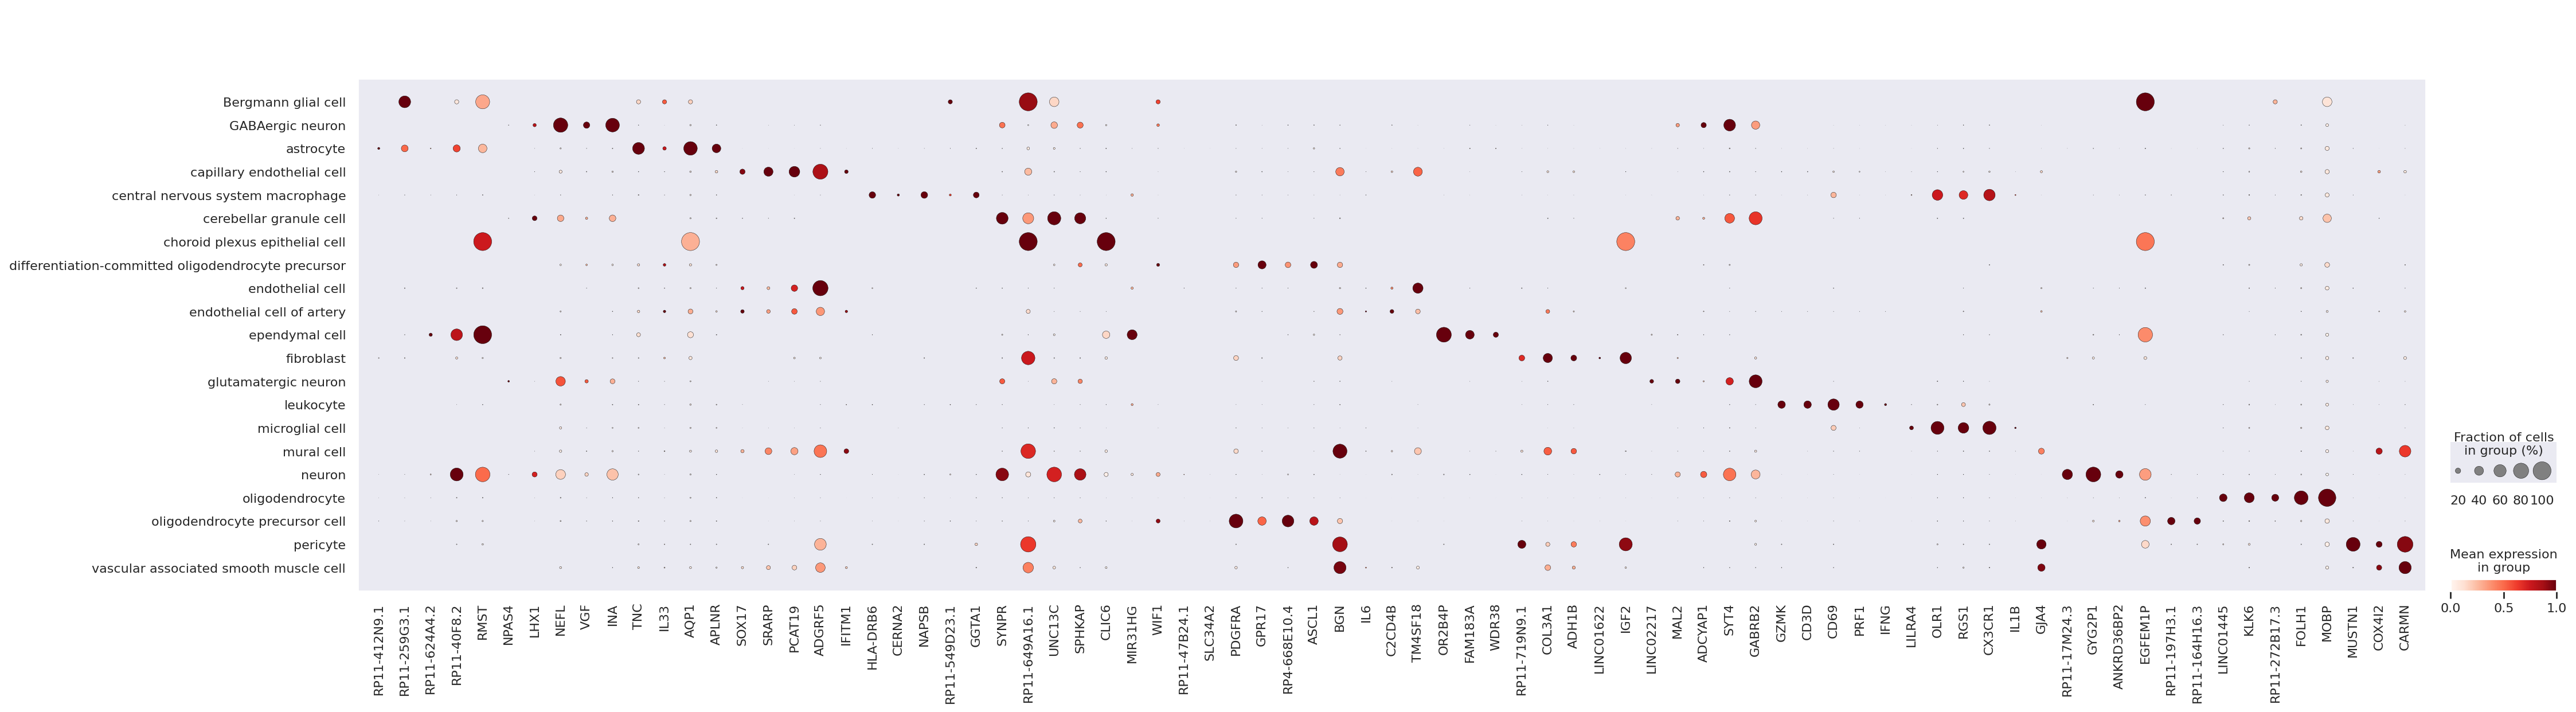

In [29]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(
    adata_log,
    marker_genes["feature_name"].to_list(),
    groupby="cell_type",
    gene_symbols="feature_name",
    standard_scale="var",
)